# Text Classification Problem
Classification of 4 types of texts (Sports, World, Business, Science/Technology)

# Data Preparation
The [training data](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=train.csv) contains 120000 samples of news articles.
The algorithm will be trained to predict the labels for test texts:
- 1 - World
- 2 - Sports
- 3 - Business
- 4 - Science/Technology


In [39]:
classes = ["World", "Sports", "Business", "Science/Technology"]

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Libraries

In [40]:
# Basic
import string
import nltk
import numpy as np
import pandas as pd

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Scickit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf

# Loading in Dataframe

In [32]:
df = pd.read_csv('./drive/MyDrive/text-classification/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Merge title and description in one column and give label

In [33]:
df['label'] = df['Class Index'].apply(lambda idx: classes[idx - 1])
df['text'] = df['Title'].astype(str) + ". " + df['Description']
df.drop(['Class Index', 'Title', 'Description'], axis=1, inplace=True)

# Data Exploration

In [34]:
pd.set_option('display.max_colwidth', None)
df.sample(10)

,label,text
40354,Business,Tokyo stocks open slightly lower. TOKYO - Stocks opened slightly lower Monday on the Tokyo Stock Exchange as declines in US technology shares last Friday prompted selling.
112092,World,"China Crime Chief Urges End to 'Social Conflicts' (Reuters). Reuters - China's security chief has urged\officials to heed the grievances of their communities, state\media reported Friday, following a series of violent protests\that undermine efforts to maintain stability."
47302,Sports,No Easy Return. Felix Trinidad's return to boxing may be timed well but it won't be easy facing the aggressive and dangerous Ricardo Mayorga.
17941,Business,"Sluggish back-to-school buying hits retail sales. Wal-Mart Stores (WMT) and other top retailers reported sluggish August sales Thursday, below Wall Street expectations, as soaring fuel prices cut into back-to-school spending."
112007,Business,"City shuts Back Bay Holiday Market. The hard luck Back Bay Holiday Market at Prudential Center was shut down for about five hours yesterday by the Boston Public Health Commission, prompting one merchant to say she plans to leave."
13502,World,"Dutch Arrest Saddam's Suspected Nerve Gas Supplier (Reuters). Reuters - Police have arrested a Dutch national\suspected of supplying thousands of tons of ingredients for\mustard gas and nerve gas to Iraq under toppled leader Saddam\Hussein, prosecutors said Tuesday."
11966,Business,U.S. Stocks Flat After GDP Data in Line. NEW YORK (Reuters) - U.S. stocks opened flat on Friday after a government report showed that the U.S. economy grew more slowly in the second quarter but at a rate that matched economists' forecasts.
46940,Science/Technology,Microsoft gives NT4 users support boost. Microsoft has improved its support for Windows NT 4.0 Server and has outlined how it will end support for e-mail system Exchange Server 5.5.
48609,World,"Why they continue to murder. Critics of the tactics that the Israel Defense Forces are employing against the terrorists of Hamas, Islamic Jihad and Al-Aqsa, which have also caused casualties among Palestinian civilians, ignore"
49451,Business,"FCC Boss Backs Cingular-ATT Wireless Deal. WASHINGTON (Reuters) - U.S. Federal Communications Commission Chairman Michael Powell plans to recommend Cingular Wireless receive approval to purchase AT T Wireless Services Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=AWE.N target=/stocks/quickinfo/fullquote""&gt;AWE.N&lt;/A&gt; with some divestitures, sources familiar with the matter said on Monday."


# Text Preprocessor

Create Text Preprocessor

In [41]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

class TextPreprocessor:
    def __init__(self, language="english", use_lemmatization=True, use_stemming=False):
        self.language = language
        self.use_stemming = use_stemming
        self.use_lemmatization = use_lemmatization
        self.__setup_default_language()

    @staticmethod
    def __tokenize_text(text):
        words = nltk.tokenize.word_tokenize(text.lower())
        return list(filter(lambda word: word not in string.punctuation, words))

    def __setup_default_language(self):
        self.stop_words = set(nltk.corpus.stopwords.words(self.language))
        if self.use_stemming:
            self.stemmer = nltk.stem.PorterStemmer()
            self.stem = self.stemmer.stem
        if self.use_lemmatization:
            self.lemmatizer = nltk.stem.WordNetLemmatizer()
            self.lemmatize = self.lemmatizer.lemmatize
            self.stemmer = nltk.stem.PorterStemmer()

    def __remove_stopwords(self, words):
        return list(filter(lambda word: word not in self.stop_words, words))

    def __stem_words(self, words):
        return map(self.stem, words)

    def __lemmatize_words(self, words):
        return map(self.lemmatize, words)

    def preprocess(self, text):
        """Preprocess the input text.

        Tokenizes the text, removes stopwords, and optionally performs lemmatization and/or stemming.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text.
        """
        tokens = self.__tokenize_text(text)
        tokens = self.__remove_stopwords(tokens)
        if self.use_lemmatization:
            tokens = self.__lemmatize_words(tokens)
        if self.use_stemming:
            tokens = self.__stem_words(tokens)
        return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Apply Text Preprocessor to dataframe

In [42]:
text_preprocessor = TextPreprocessor()
df['text'] = df['text'].apply(lambda txt: text_preprocessor.preprocess(txt))
df.sample(5)

,label,text
53788,Science/Technology,mar rover plot crater 39 escape 39 twin keep climbing hill nasa 39 mar rover 39 seem wearing mission planner begun think boldly including plan let one climb steep quot escape hatch quot crater exploring set trek across plain
128,Science/Technology,space science pioneer van allen question human spaceflight space.com space.com leading space scientist called question validity human spaceflight suggesting sending astronaut outward earth outdated costly science returned trivial
119663,Sports,van nistelrooy set scan beijing dec. 16 -- manchester united striker ruud van nistelrooy set scan bid try find root cause calf problem
17443,World,tennis agassi go andre agassi go florian mayer forced retire injured
56626,Business,singapore 39 growth slows third quarter singapore 39 economic growth slowed 7.7 percent third quarter 12.5 percent rise previous three month central bank said would keep tight rein monetary policy support growth amid rising oil price


# Train Test Split

In [43]:
X_train, X_temp = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 25)
X_test, X_val = train_test_split(X_temp, test_size = 0.5, stratify = X_temp['label'], random_state = 25)

X_train2, X_temp2 = train_test_split(df, test_size = 0.999, stratify = df['label'], random_state = 25)
X_test2, X_val2 = train_test_split(X_temp2, test_size = 0.001 / 0.999, stratify = X_temp2['label'], random_state = 25)

print(f'The shape of train data {X_train.shape}')
print(f'The shape of validation data {X_val.shape}')
print(f'The shape of test data {X_test.shape}')


print(f'The shape 2 of train data {X_train2.shape}')
print(f'The shape 2 of validation data {X_val2.shape}')
print(f'The shape 2 of test data {X_test2.shape}')

The shape of train data (96000, 2)
The shape of validation data (12000, 2)
The shape of test data (12000, 2)
The shape 2 of train data (120, 2)
The shape 2 of validation data (120, 2)
The shape 2 of test data (119760, 2)


Сreate a barplot to see the class distribution.

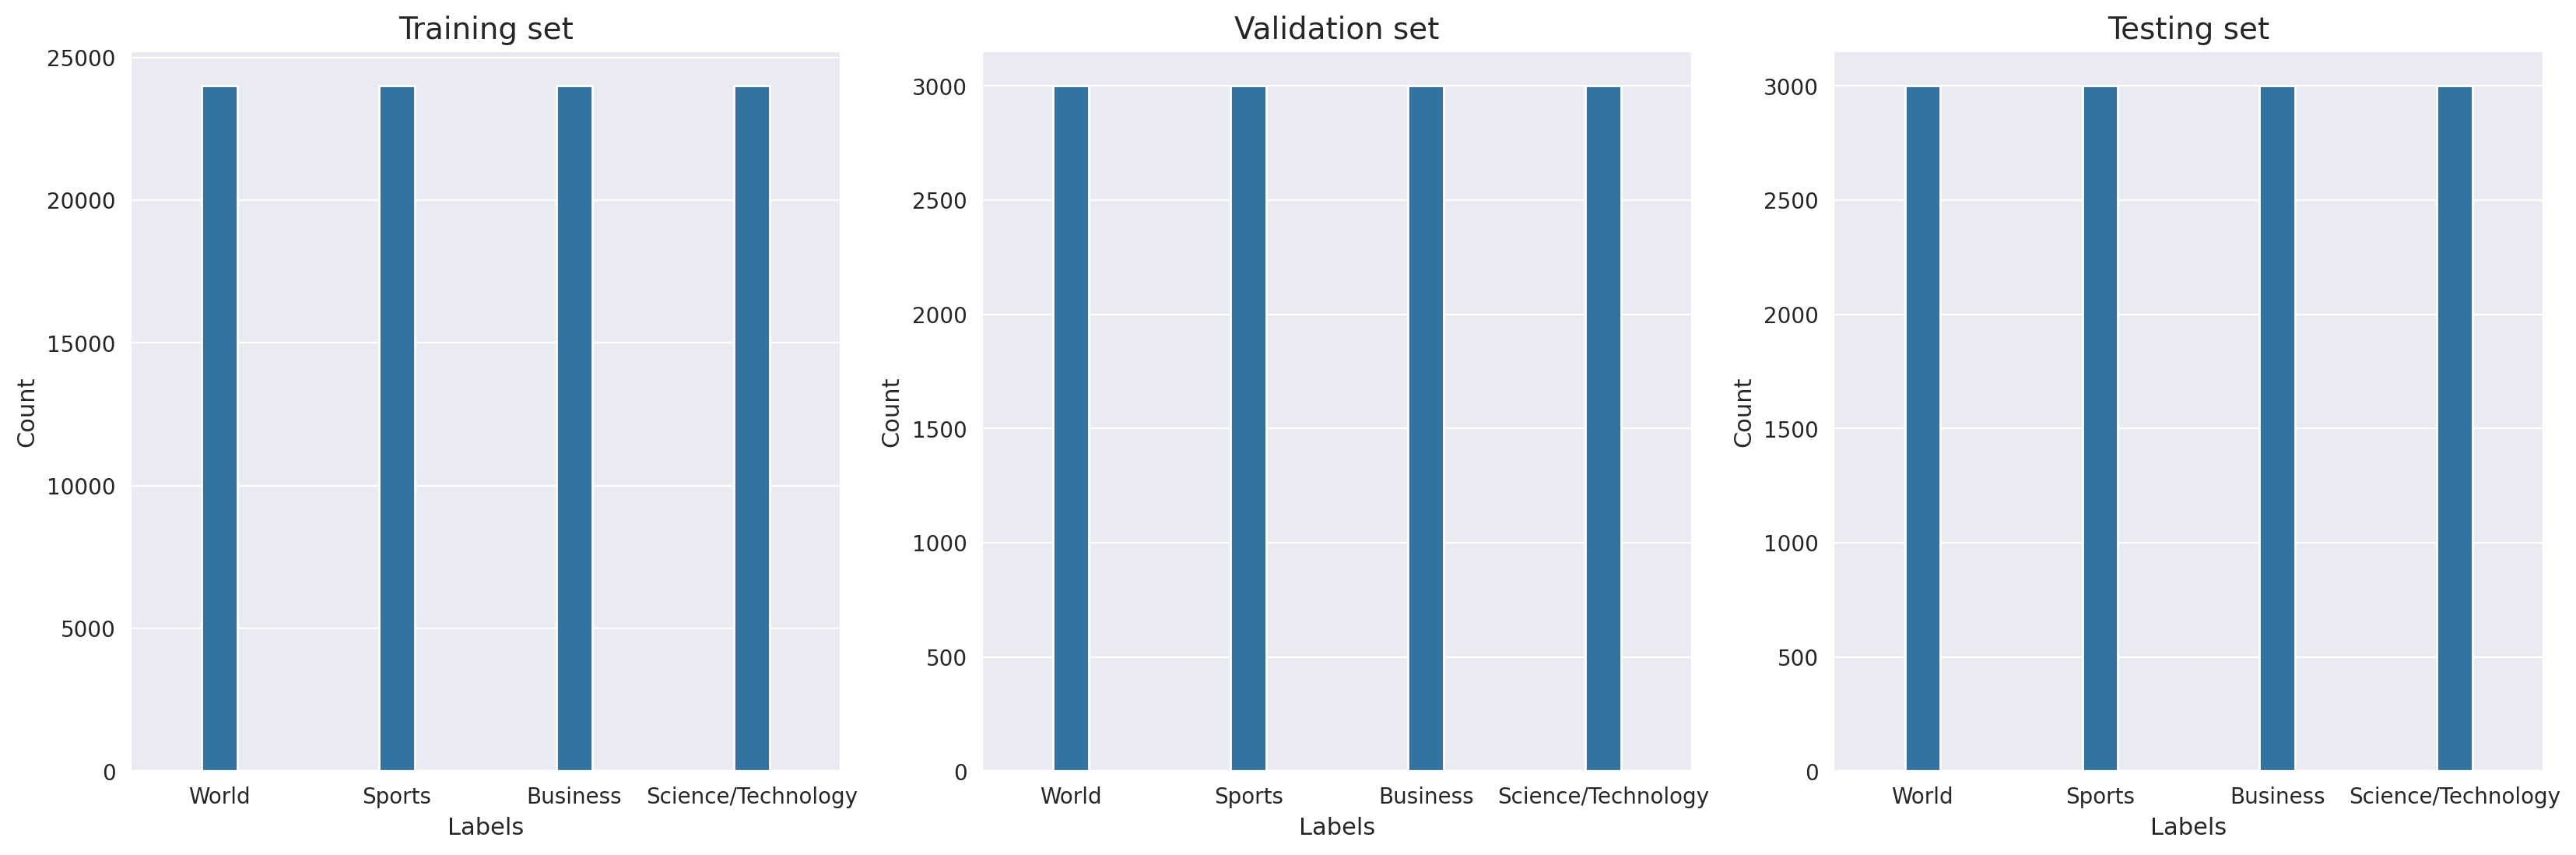

In [44]:
label1, count1 = np.unique(X_train.label,return_counts=True)
label2, count2 = np.unique(X_val.label,return_counts=True)
label3, count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=classes,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=classes,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=classes,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',width=0.2).set_title('Training set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',width=0.2).set_title('Validation set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',width=0.2).set_title('Testing set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.show()

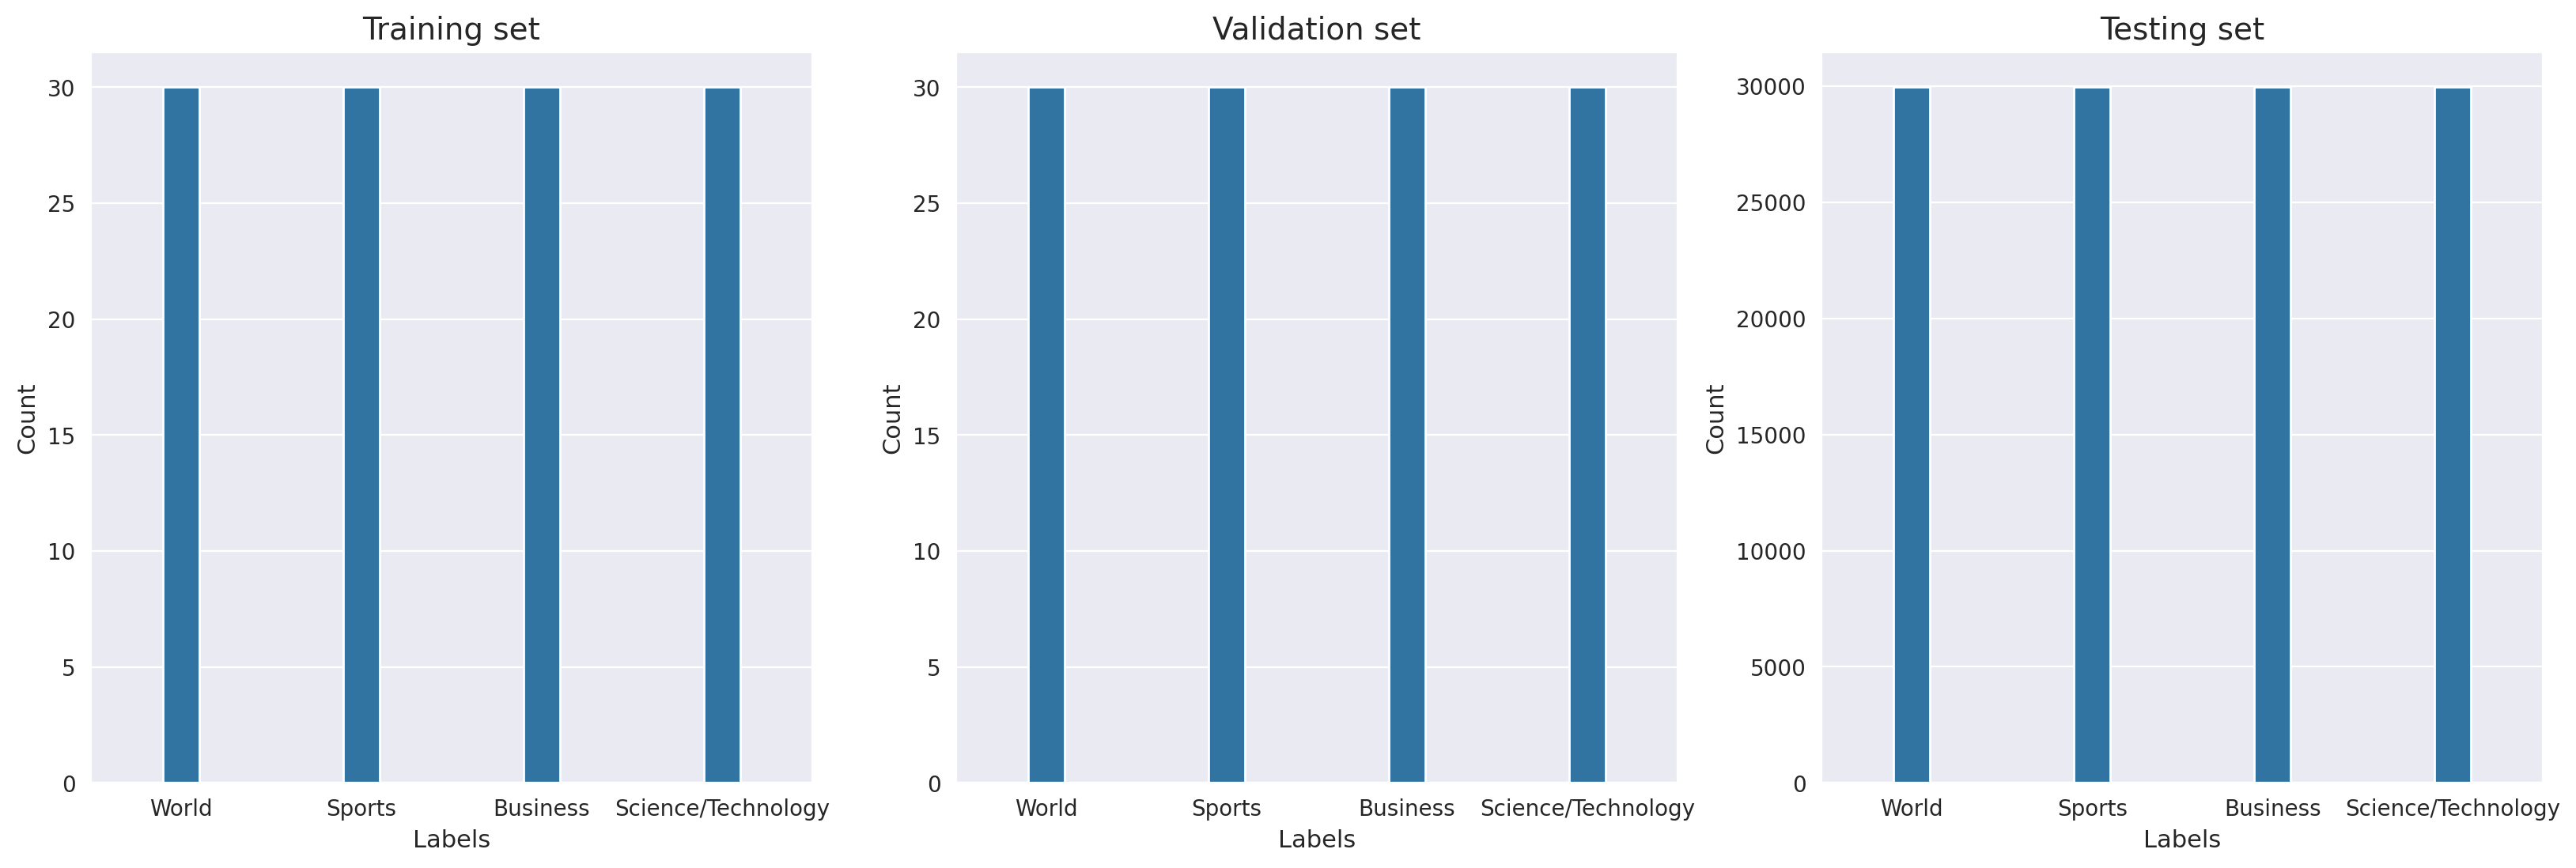

In [45]:
label1, count1 = np.unique(X_train2.label,return_counts=True)
label2, count2 = np.unique(X_val2.label,return_counts=True)
label3, count3 = np.unique(X_test2.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=classes,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=classes,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=classes,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',width=0.2).set_title('Training set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',width=0.2).set_title('Validation set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',width=0.2).set_title('Testing set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.show()

# Model

Create dataset

In [46]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

categories = X_train['label'].astype('category').cat.categories.tolist()

train_ds = tf.data.Dataset.from_tensor_slices((X_train['text'].to_numpy(), X_train['label'].astype('category').cat.codes))
valid_ds = tf.data.Dataset.from_tensor_slices((X_val['text'].to_numpy(), X_val['label'].astype('category').cat.codes))
test_ds = tf.data.Dataset.from_tensor_slices((X_test['text'].to_numpy(), X_test['label'].astype('category').cat.codes))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Create the text encoder

In [47]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())


Create model

In [48]:
EMBEDDING_DIM = 64
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                      

# Callbacks

In [49]:
 early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                          patience=2,
                                                          min_delta=1e-3,
                                                          verbose=1,
                                                          restore_best_weights=True)

# Compile the Model
- Optimizer: Adam(default)
- Loss: Categorical Crossentropy
- Metrics: Accuracy

In [50]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Fit the Model

We are now going to train our compiled model. The model will be trained for 5 epochs.

In [51]:
model_history = model.fit(train_ds,
                          validation_data=valid_ds,
                          callbacks=[early_stopping],
                          epochs=50)

Epoch 1/50
1500/1500 [==============================] - 213s 135ms/step - loss: 0.5029 - accuracy: 0.8224 - val_loss: 0.2841 - val_accuracy: 0.9046
Epoch 2/50
1500/1500 [==============================] - 180s 120ms/step - loss: 0.2496 - accuracy: 0.9189 - val_loss: 0.2655 - val_accuracy: 0.9088
Epoch 3/50
1500/1500 [==============================] - 183s 122ms/step - loss: 0.2036 - accuracy: 0.9330 - val_loss: 0.2630 - val_accuracy: 0.9118
Epoch 4/50
1500/1500 [==============================] - 178s 119ms/step - loss: 0.1770 - accuracy: 0.9414 - val_loss: 0.2742 - val_accuracy: 0.9104
Epoch 5/50
1500/1500 [==============================] - 179s 119ms/step - loss: 0.1552 - accuracy: 0.9484 - val_loss: 0.2749 - val_accuracy: 0.9083
Epoch 5: early stopping


Plot the result

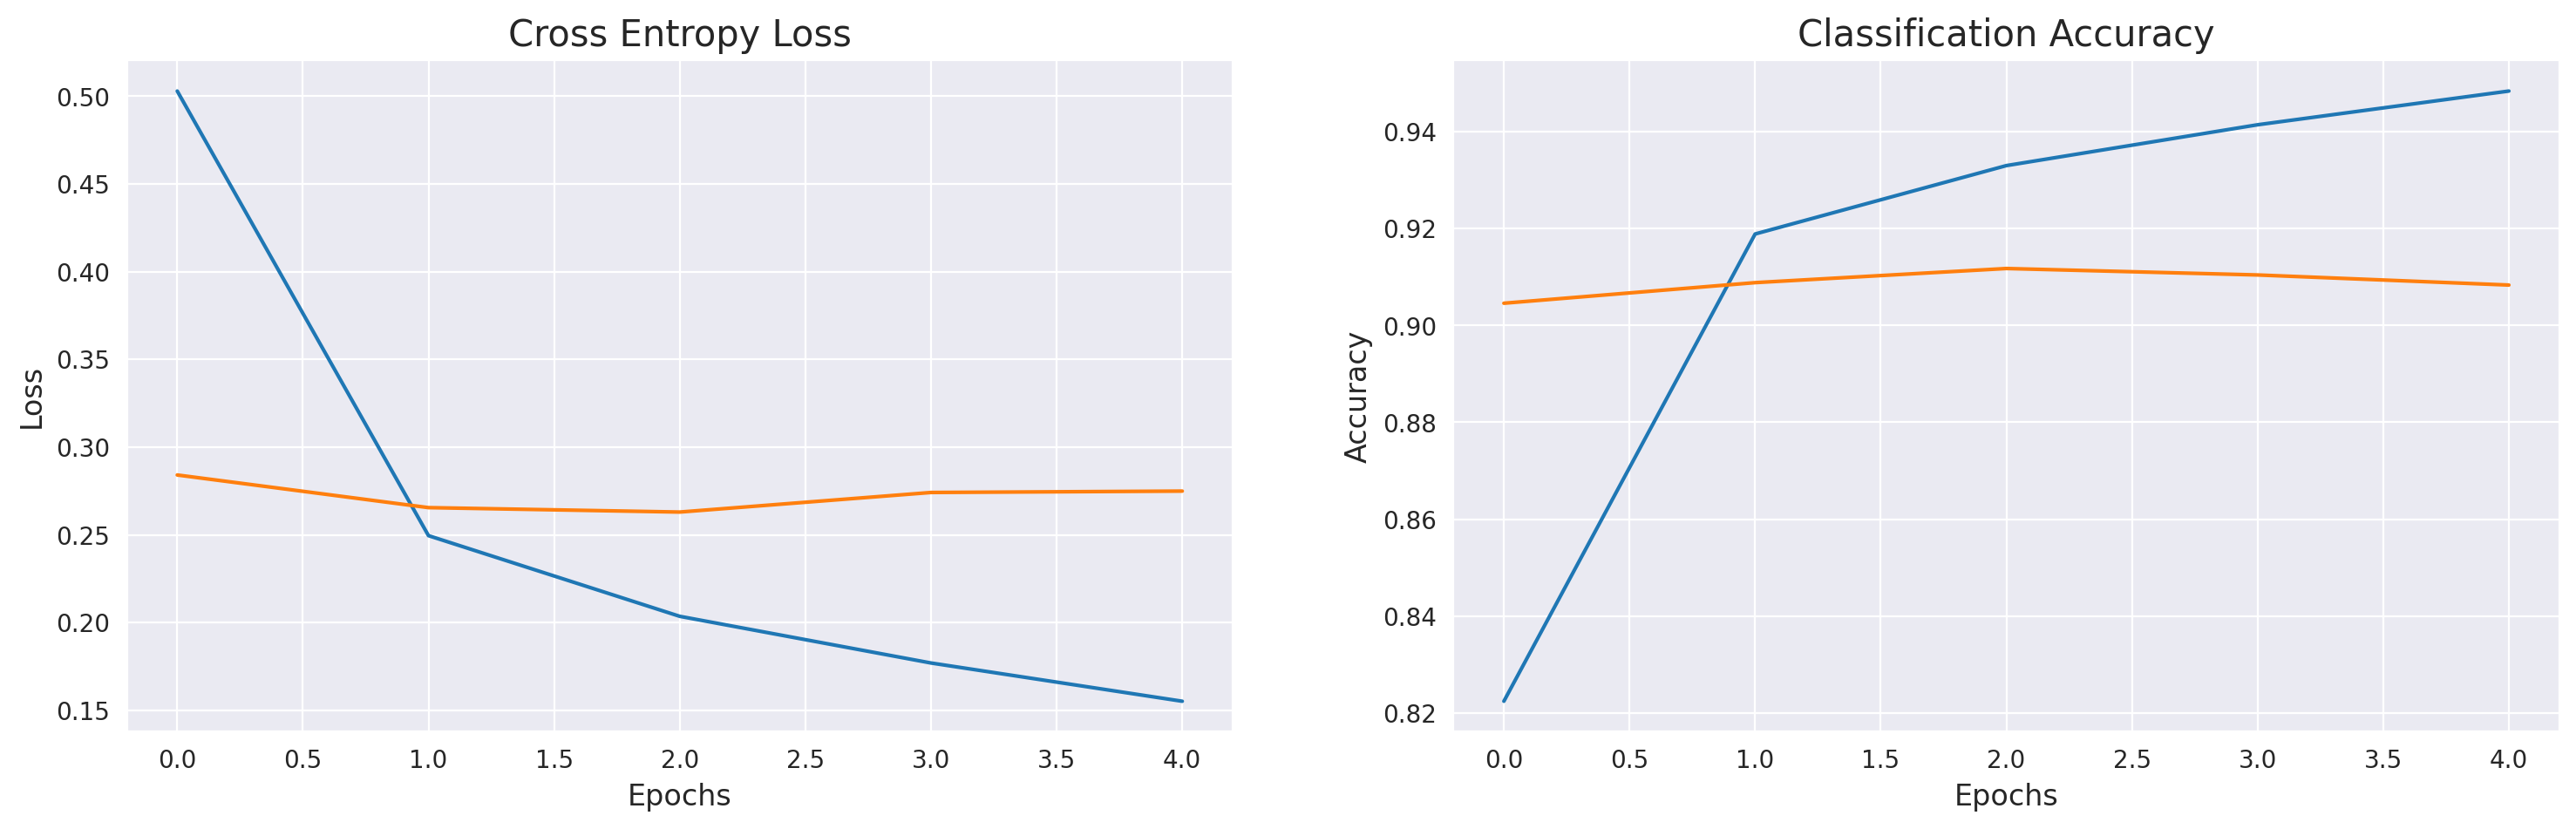

In [52]:
error = pd.DataFrame(model_history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.plot(error ['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

# Evaluation

In [53]:
loss, acc = model.evaluate(train_ds)
print('The accuracy of the model for training data is: ', acc*100)
print('The loss of the model for training data is:', loss)

loss, acc = model.evaluate(valid_ds)
print('The accuracy of the model for validation data is:', acc*100)
print('The loss of the model for validation data is:', loss)

1500/1500 [==============================] - 49s 33ms/step - loss: 0.1503 - accuracy: 0.9520
The accuracy of the model for training data is:  95.20208239555359
The loss of the model for training data is: 0.15030652284622192
188/188 [==============================] - 7s 36ms/step - loss: 0.2630 - accuracy: 0.9118
The accuracy of the model for validation data is: 91.17500185966492
The loss of the model for validation data is: 0.2630007266998291


Save the model

In [54]:
model.save("model.keras")

# Prediction

In [56]:
result = model.predict(test_ds)

y_pred = np.argmax(result, axis = 1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
loss, acc = model.evaluate(test_ds)

print('The accuracy of the model for testing data is:', acc*100)
print('The loss of the model for testing data is:', loss)

188/188 [==============================] - 7s 36ms/step - loss: 0.2678 - accuracy: 0.9105
The accuracy of the model for testing data is: 91.04999899864197
The loss of the model for testing data is: 0.26782718300819397


Classification report

In [57]:
print(classification_report(y_true, y_pred, target_names = classes))

                    precision    recall  f1-score   support

             World       0.87      0.90      0.88      3000
            Sports       0.89      0.88      0.88      3000
          Business       0.96      0.97      0.96      3000
Science/Technology       0.93      0.89      0.91      3000

          accuracy                           0.91     12000
         macro avg       0.91      0.91      0.91     12000
      weighted avg       0.91      0.91      0.91     12000



Confusion matrix

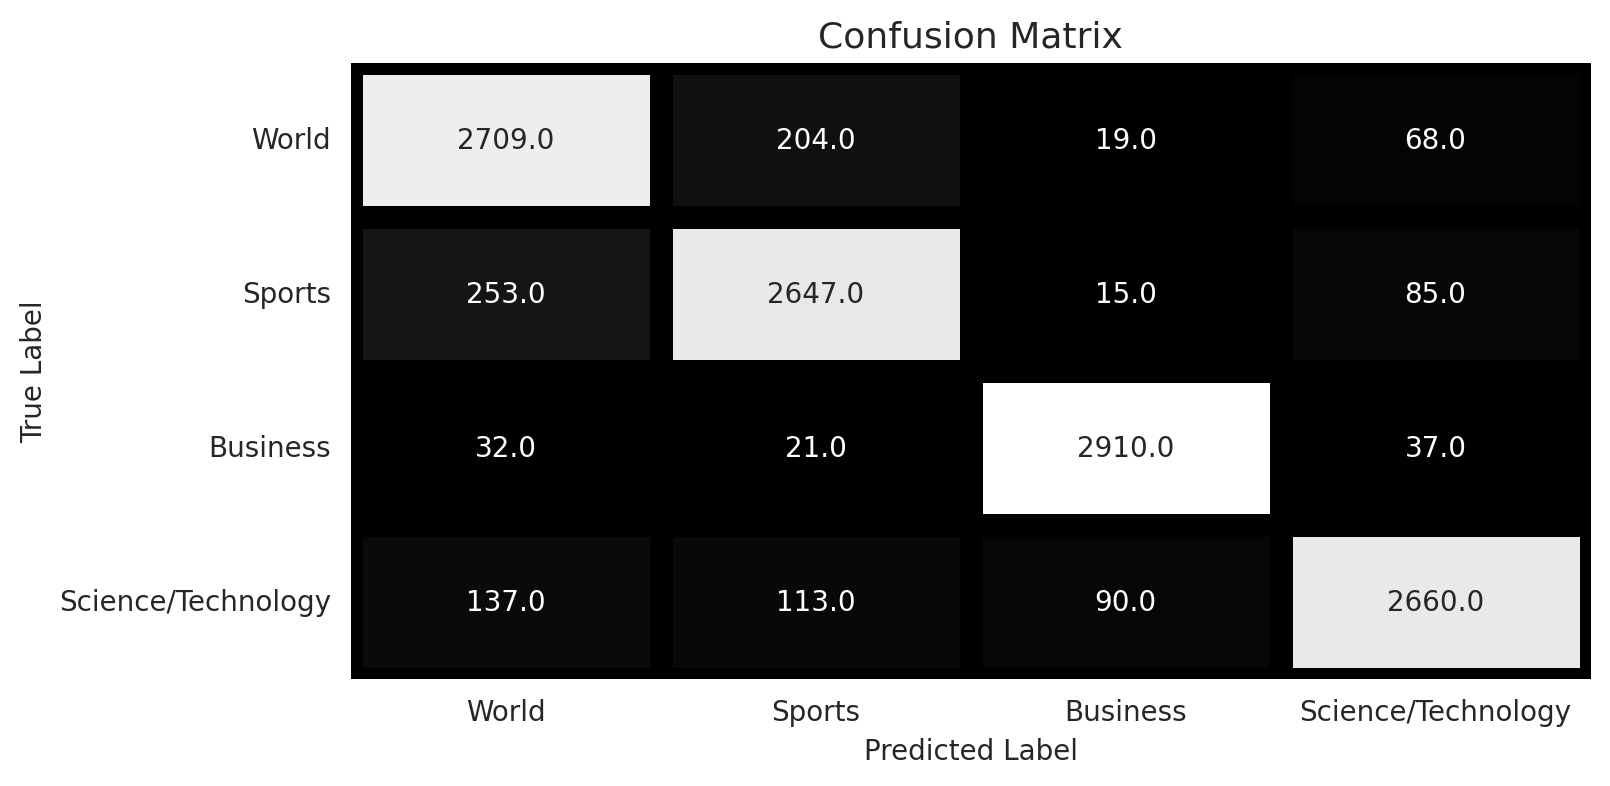

In [58]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx,
            annot=True,
            linewidths=8.1,
            cmap="gist_yarg_r",
            linecolor="black",
            fmt=".1f",
            ax=ax,
            cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)

plt.title("Confusion Matrix", fontsize=13)

plt.show()

Check classification on random samples

In [59]:
sample_text = """
In the realm of technology, artificial intelligence (AI) stands as a revolutionary force, reshaping industries, augmenting human capabilities, and fueling innovation.
Through advanced algorithms and computational power, AI systems can analyze vast datasets, recognize patterns, and make autonomous decisions with unprecedented accuracy and efficiency.
From virtual assistants streamlining daily tasks to self-driving cars navigating complex environments, the potential applications of AI are vast and continually expanding.
While unlocking new possibilities, AI also raises ethical and societal considerations, prompting discussions on privacy, bias, and the future of work in an increasingly automated world.
"""

# Preprocess the text sample (replace this with your actual preprocessing steps)
processed_text =  text_preprocessor.preprocess(sample_text)
print(processed_text)

# Make predictions
predictions = model.predict(np.array([processed_text]))

predicted_probabilities = predictions[0]
# Create a list of tuples containing category index and probability
category_prob_tuples = [(i, prob) for i, prob in enumerate(predicted_probabilities)]
# Sort the list of tuples by probability in descending order
sorted_category_prob_tuples = sorted(category_prob_tuples, key=lambda x: x[1], reverse=True)
# Display the results
for i, (category_index, probability) in enumerate(sorted_category_prob_tuples):
    print(f"{i+1}. Category: {categories[category_index]}, Probability: {probability}")

realm technology artificial intelligence ai stand revolutionary force reshaping industry augmenting human capability fueling innovation advanced algorithm computational power ai system analyze vast datasets recognize pattern make autonomous decision unprecedented accuracy efficiency virtual assistant streamlining daily task self-driving car navigating complex environment potential application ai vast continually expanding unlocking new possibility ai also raise ethical societal consideration prompting discussion privacy bias future work increasingly automated world
1/1 [==============================] - 3s 3s/step
1. Category: Science/Technology, Probability: 0.9810492992401123
2. Category: Business, Probability: 0.016281887888908386
3. Category: Sports, Probability: 0.0014662211760878563
4. Category: World, Probability: 0.0012026274343952537
